# Prototyping 1D EFGP 

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

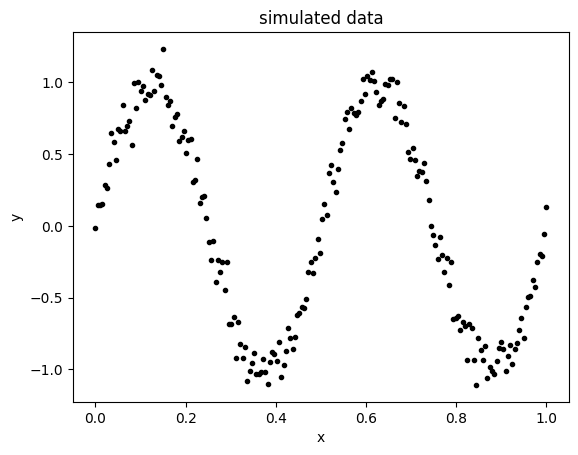

In [2]:
# generate data 
N = 200
freq = 2    
x = torch.linspace(0, 1, N)
y = torch.sin(2 * torch.pi * freq * x) + torch.randn(N) * 0.1

# plot data
plt.plot(x, y, 'k.')
plt.xlabel('x')
plt.ylabel('y')
plt.title('simulated data')
plt.show()


In [3]:
from utils.kernels import get_xis
from kernels.squared_exponential import SquaredExponential

kernel = SquaredExponential(dimension=1, lengthscale=0.1, variance=1.0)

In [4]:
# Determine problem geometry
L = x[-1] - x[0]
N = x.shape[0]
EPSILON = 1e-5
xis, h, mtot = get_xis(kernel_obj=kernel, eps=EPSILON, L=L, use_integral=False, l2scaled=False)


In [5]:
print("Mtot: ", mtot)
print("h: ", h)
print("xis: ", xis)

Mtot:  29
h:  tensor(0.6540)
xis:  tensor([-9.1557, -8.5017, -7.8477, -7.1937, -6.5398, -5.8858, -5.2318, -4.5778,
        -3.9239, -3.2699, -2.6159, -1.9619, -1.3080, -0.6540,  0.0000,  0.6540,
         1.3080,  1.9619,  2.6159,  3.2699,  3.9239,  4.5778,  5.2318,  5.8858,
         6.5398,  7.1937,  7.8477,  8.5017,  9.1557])


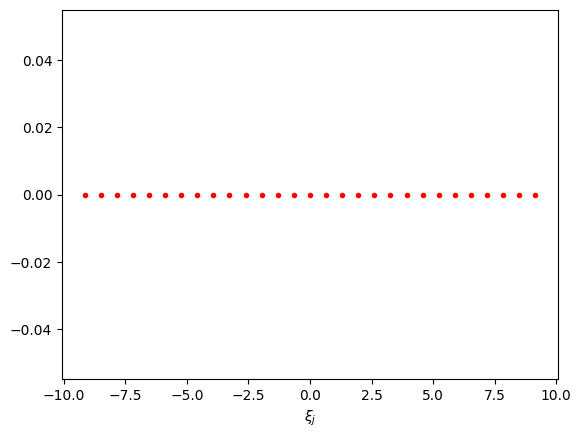

In [6]:
# plot a line with tics on the xis
plt.plot(xis, torch.zeros(mtot), 'r.')
plt.xlabel(r'$\xi_j$')
plt.show()

In [7]:
ws = torch.sqrt(kernel.spectral_density(xis) * h)

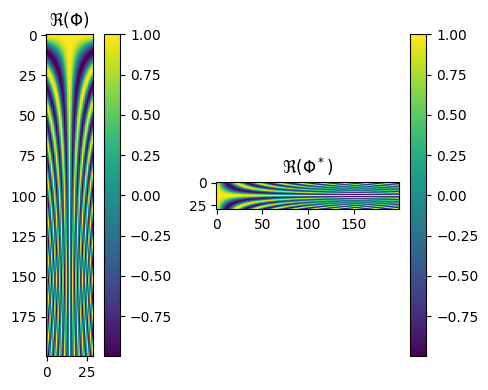

In [9]:
# Form design matrix Phi and system matrix A
# We do so manually here for clarity (no FFT / NUFFT)
Phi = torch.exp(1j * 2 * torch.pi * torch.outer(x, xis))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 4))

im1 = ax1.imshow(Phi.real)
plt.colorbar(im1, ax=ax1)
ax1.set_title(r'$\Re(\Phi)$')

im2 = ax2.imshow(Phi.conj().T.real)
plt.colorbar(im2, ax=ax2)
ax2.set_title(r'$\Re(\Phi^*)$')

plt.tight_layout()
plt.show()

# ws_diag = torch.diag(ws).to(dtype=Phi.dtype) # complex dtype
# A = ws_diag @ (Phi.T @ Phi) @ ws_diag


In [10]:
# create a matrix of distances between x's
dist_matrix = torch.cdist(x.unsqueeze(-1), x.unsqueeze(-1))
kernel_matrix = kernel.kernel(dist_matrix)

In [11]:
ws = ws.to(dtype=torch.complex128)
Phi = Phi.to(dtype=torch.complex128)
kernel_approx =  ((Phi @ torch.diag(ws)) @ (torch.diag(ws) @ torch.conj(Phi).T))


Text(0.5, 0.98, 'Approximating kernel matrix with equispaced features, N = 200, M = 29')

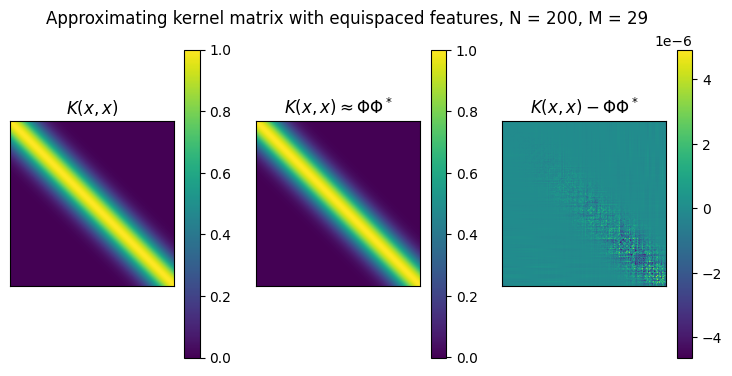

In [12]:
# subplot kernel matrix, kernel approx, and difference side by side
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 4))

im1 = ax1.imshow(kernel_matrix)
plt.colorbar(im1, ax=ax1)
ax1.set_title(r'$K(x, x)$')
# no axis labels
ax1.set_xticks([])
ax1.set_yticks([])

im2 = ax2.imshow(kernel_approx.real)
plt.colorbar(im2, ax=ax2)
ax2.set_title(r'$K(x, x) \approx \Phi \Phi^*$')
ax2.set_xticks([])
ax2.set_yticks([])

diff = kernel_matrix - kernel_approx.real
im3 = ax3.imshow(diff)
plt.colorbar(im3, ax=ax3)
ax3.set_title(r'$K(x, x) - \Phi \Phi^*$')
ax3.set_xticks([])
ax3.set_yticks([])

plt.suptitle(f'Approximating kernel matrix with equispaced features, N = {N}, M = {mtot}')



In [13]:
from efgp_1d_dense import efgp1d_dense

In [14]:
x_input = torch.cat([x[:30], x[60:70], x[70:90]])
y_input = torch.cat([y[:30], y[60:70], y[70:90]])


In [15]:
beta, xis, ytrg, A, F, ws = efgp1d_dense(x_input, y_input, sigmasq=torch.tensor(0.1), kernel=kernel, eps=EPSILON, x_new=x, opts={'get_var': True})

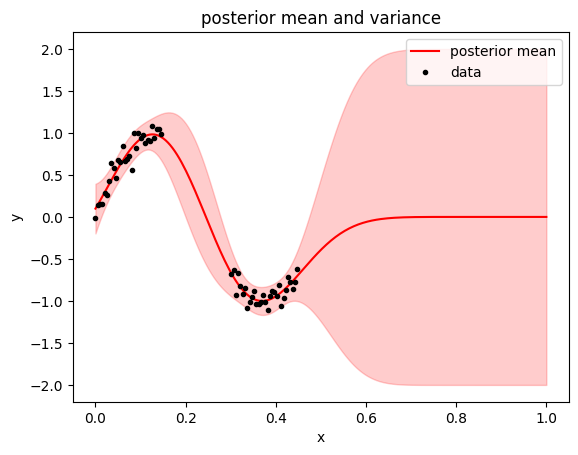

In [16]:
# plot the beta
# plt.plot(x, train_posterior['mean'], 'r-', label='posterior mean')
plt.plot(x, ytrg['mean'], 'r-', label='posterior mean')
# shaded region for +- 2 std
plt.fill_between(x, ytrg['mean'] - 2 * torch.sqrt(ytrg['var']), ytrg['mean'] + 2 * torch.sqrt(ytrg['var']), color='r', alpha=0.2)
plt.plot(x_input, y_input, 'k.', label='data')
plt.xlabel('x')
plt.ylabel('y')
plt.title('posterior mean and variance')
plt.legend()
plt.show()

In [14]:
# old version keeping here for reference, remove later
def efgp1d_dense(x, y, sigmasq, kernel, eps, xsol, opts=None):
    """
    Dense solve version of EFGP in 1D using PyTorch.
    
    Args:
        x: (N,) tensor of observation locations
        y: (N,) tensor of observations
        sigmasq: float, residual variance for GP regression
        kernel: object with methods k() and khat() for covariance kernel and its Fourier transform
        eps: float, truncation tolerance
        xsol: (Nsol,) tensor of locations for posterior mean evaluation
        opts: optional dict of parameters (only 'get_var' used currently)
    
    Returns:
        dict containing:
            beta: (M,) tensor of Fourier basis weights
            xis: (M,) tensor of Fourier frequencies used
            ytrg: dict with posterior means and optionally variances
            A: (M,M) system matrix (for debugging)
            X: (N,M) design matrix (for debugging)
            ws: (M,) weights for scaling complex exponentials
    """
    x = x.to(dtype=torch.float64)
    y = y.to(dtype=torch.float64)
    xsol = xsol.to(dtype=torch.float64)
    # Get problem geometry
    x0, x1 = torch.min(torch.cat([x, xsol])), torch.max(torch.cat([x, xsol]))
    L = x1 - x0
    N = x.shape[0]
    
    # Get Fourier frequencies and weights
    xis, h, mtot = get_xis(kernel, eps, L)  # assume this exists and returns tensors
    ws = torch.sqrt(kernel.spectral_density(xis) * h)
    
    # Form design matrix X and system matrix A
    X = torch.exp(1j * 2 * torch.pi * torch.outer(x, xis)).to(dtype=torch.complex128)
    ws_diag = torch.diag(ws).to(dtype=torch.complex128) # complex dtype
    A = ws_diag @ (torch.conj(X).T @ X) @ ws_diag
    
    # Solve linear system for beta
    rhs = ws_diag @ torch.conj(X).T @ y.to(dtype=torch.complex128) # y to complex dtype
    
    # Solve using Cholesky factorization
    chol_factor = torch.linalg.cholesky(A + sigmasq * torch.eye(mtot, dtype=A.dtype))
    beta = torch.cholesky_solve(rhs.unsqueeze(-1), chol_factor).squeeze(-1)
    
    # beta = torch.linalg.solve(A + sigmasq * torch.eye(mtot, dtype=A.dtype), rhs)

    # Evaluate posterior mean at target points
    Xsol = torch.exp(1j * 2 * torch.pi * torch.outer(xsol, xis)) @ ws_diag
    yhat = Xsol @ beta
    
    ytrg = {'mean': torch.real(yhat)}
    
    # Optionally compute posterior variance
    if opts is not None and opts.get('get_var', False):
        nsol = len(xsol)
        c = (A / sigmasq) + torch.eye(mtot, dtype=A.dtype)
        c_inv = torch.linalg.inv(c)
        fs = torch.exp(1j * 2 * torch.pi * torch.outer(xsol, xis)) @ ws_diag
        ytrg['var'] = torch.real(torch.diagonal(fs @ c_inv @ fs.T.conj()))
    
    return beta, xis, ytrg, A, X, ws
